# Open exploration - levers

- Perform experiments for five sampled scnenarios and 1,000 sampled policies (both sampling using lhs).
- Evaluate the influence of different policy levers have on the outcomes: (1) expected damage, (2) expected number of deaths, and (3) total costs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id

In [3]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= 5, policies = 1000)

save_results(results, './results/open_exploration_policies_5000runs.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5 scenarios * 1000 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_policies_5000runs.tar.gz


Wall time: 43min 21s


In [4]:
results = load_results('./results/open_exploration_policies_5000runs.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_policies_5000runs.tar.gz


## The outcomes

We first inspect the outcomes by boxplots. From the graphs we can see that the results for *Total Investment Costs* is quite normally distributed, while those for *Expected Annual Damage* and *Expected Number of Deaths* contain many extreme "outliers". These findings are aligned with the following parewise scatterplot.

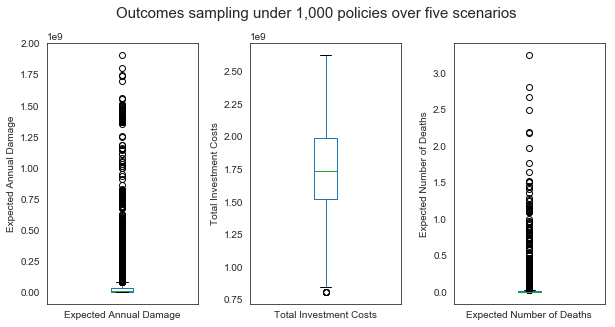

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.35, top = 0.85)
kpis = pd.DataFrame([key.name for key in dike_model.outcomes])
fig.suptitle('Outcomes sampling under 1,000 policies over five scenarios', y=0.95, fontsize=15)

for i, key in kpis.iterrows():
    pd.Series(outcomes[key[0]]).plot(kind='box', ax=axes[i], label=key[0])
    axes[i].set_ylabel(key[0])

## Pairwise scatterplot

From the graphs we can see that there is a correlation between *Expected Annual Damage* and *Expected Number of Deaths*. 
A higher *Total Investment Costs* does NOT necessarily lead to less damage or deaths. In addition, irrespective of total investment costs, both expected damage and deaths are highly concentrated below a certain threshold, with some extreme outliers spreaded across various values of total investment costs. This was also observed from the previous boxplots.

We can also see from this graph that there is NO significant differences of outcomes across the sampled scenarios.

[MainProcess/INFO] no time dimension found in results


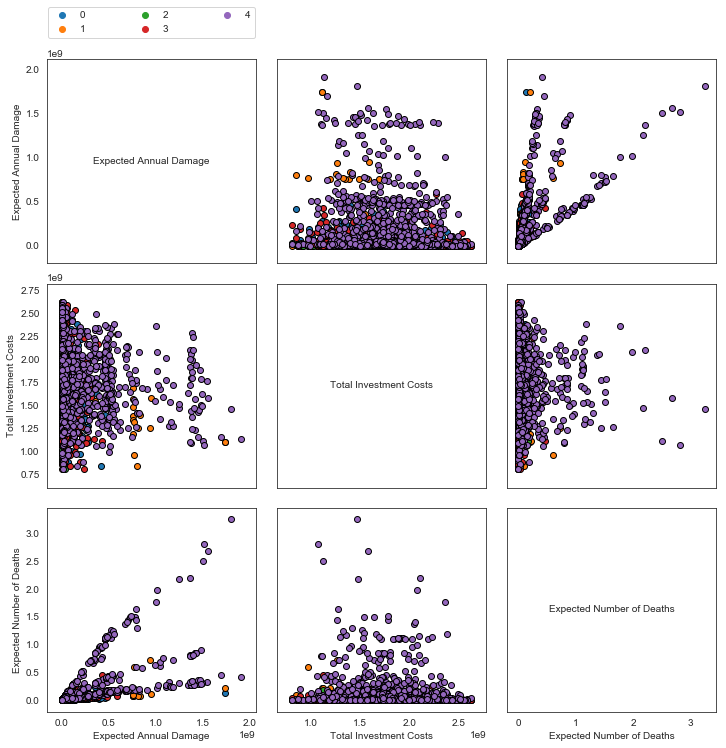

In [14]:
fig, ax = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='scenario', legend=True)
fig.set_size_inches([12, 12])

## Feature scoring

We then perform feature scoring for all outcomes to find out on which outcome does which lever has the largest influence.

From the results, we see that *Expected Annual Damage* is primarily influenced by **dike heightening at Zutphen (A.3)**, while RfR at Doesburg (A.1), Cortenover (A.2) and Deventer (A.5) seem to have very limited influence on the outcome of expected damage.

*Total Investment Costs* is most influenced by the **RfR levers at Cortenover (A.2) and Deventer (A.5)**.

The *Expected Number of Deaths* is also highly influenced by **dike heightening at Zutphen (A.3)** as well as the **evacuation** lever.

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


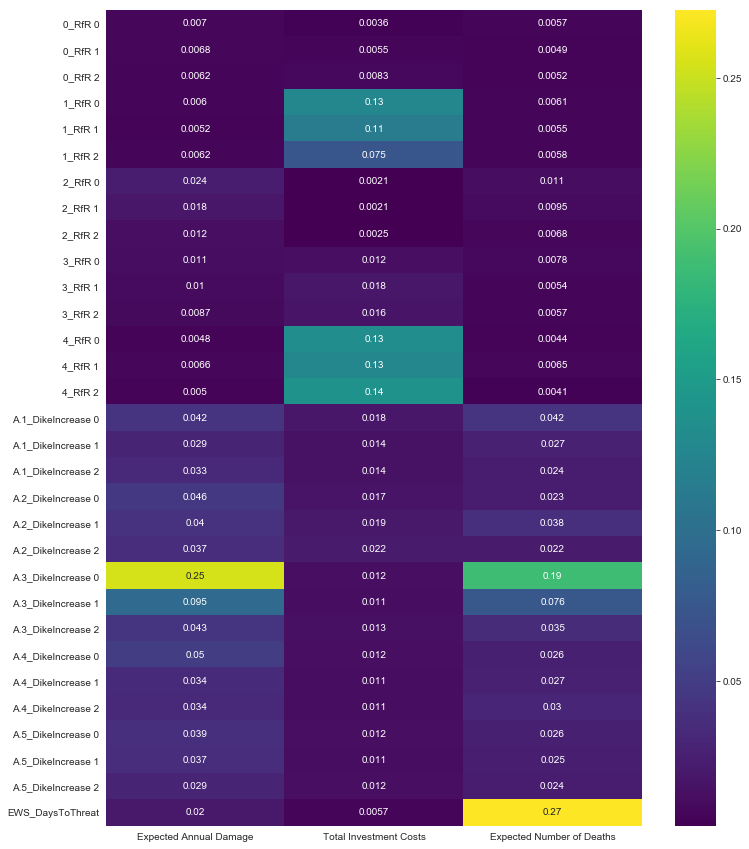

In [19]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y, alg='random forest')
plt.figure(figsize = (12,15))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

## Dimensional stacking & PRIM

We can further apply dimensional stacking to create a heatmap showing the influences of the most important levers, and PRIM to identify the range of the levers. We can plot it for all three outcomes of interest. 

As we saw previously, the *Expected Annual Damage* and *Expected Number of Deaths* both have a very narrow box in the boxplot with quite some (extreme) outlies. We can therfore use Q3 as a threshold for these two outcomes of interest. As a further investigation, we will also use < 0.5 as a threshold for the expected number of deaths to evaluate the absolute value of outcome.

### 1. Expected Annual Damage < its 75th percentile

The dimensional stacking plot shows that the most powerful levers on expected damage are: dike heightening at Zutphen (A.3), Deventer (A.5) and Cortenover (A.2) at the first timestep and RfR at Gorssel (A.4) at all three timesteps. In addition, a larger increase in dike height has a stronger influence on expected damage. This can be better understood from PRIM, where the results show that the levers of (a) **dike heightening at Zutphen (A.3) for more than 5.5 dm**, (b) **dike heightening at Deventer (A.5) for more than 3.5 dm** and (c) **dike heightening at Cortenover (A.2) for more than 3.5 dm** contribute to an expected annual damage below the Q3 threhold among the sampled experiments.

[MainProcess/INFO] model dropped from analysis because only a single category


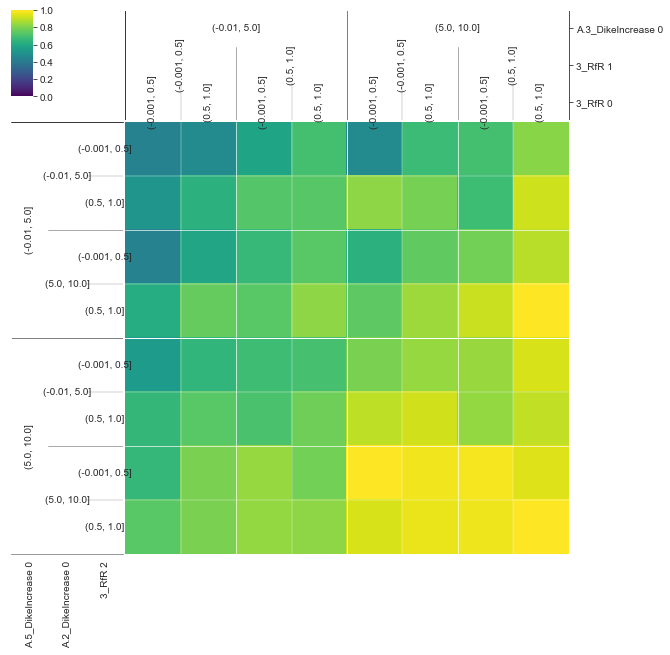

In [35]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes['Expected Annual Damage'] < np.percentile(outcomes['Expected Annual Damage'], q=75)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [31]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.9)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 3749 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.107, coverage: 0.1427047212590024, density: 1.0 restricted_dimensions: 9


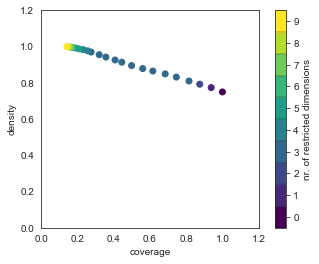

In [32]:
box1.show_tradeoff()
plt.show()

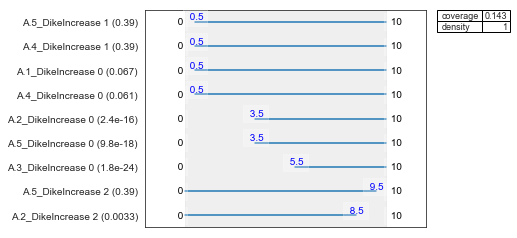

In [33]:
box1.inspect(style='graph')
plt.show()

### 2. Total Investment Costs < its mean

As observed from the boxplot of outcomes, the results for *Total Investment Costs* is quite normally distributed. Therefore we use its mean value as the threshold for dimensional stacking and PRIM. From dimensional stacking and PRIM, we can see that **RfR at Cortenover (A.2)** and **RfR at Deventer (A.5)** at the first timestep are the most expensive levers.

[MainProcess/INFO] model dropped from analysis because only a single category


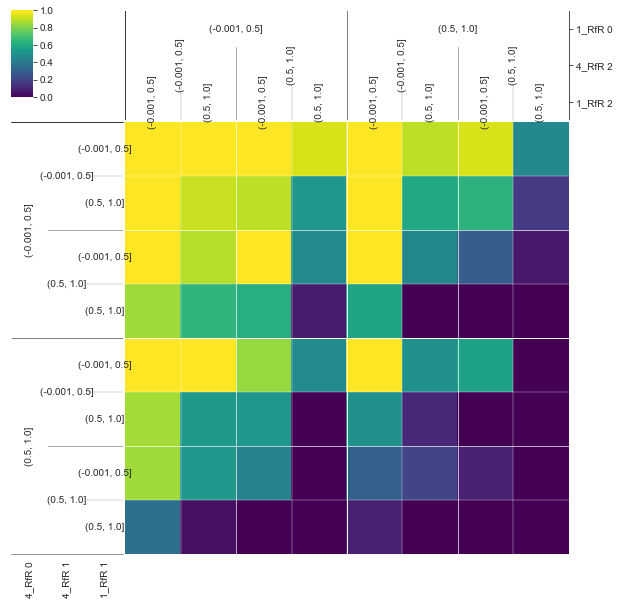

In [45]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes['Total Investment Costs'] < np.percentile(outcomes['Total Investment Costs'], q=50)
dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [46]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box2 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.062, coverage: 0.124, density: 1.0 restricted_dimensions: 6


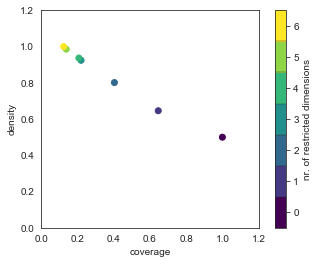

In [47]:
box2.show_tradeoff()
plt.show()

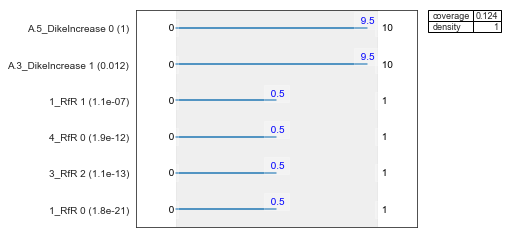

In [48]:
box2.inspect(style='graph')
plt.show()

### 3. Expected Number of Deaths

We use Q3 and 0.5 as thresholds for *Expected Number of Deaths* as explained previously. 

#### 3.1 Expected Number of Deaths < its 75th percentile

From dimensional stacking and PRIM, we can see that **dike heightening at Zutphen (A.3) for more than 5.5 dm** at the first timestep is the most powerful lever on reducing the (relatively) expected number of deaths. The **early warning of evacuation for more than 1.5 days** is the second most powerful lever. Besides that, **dike heightening at Cortenover (A.2) and Deventer (A.5)** at the first timestep are also levers that outperformed the rests.

In [40]:
# check the threshold value
print('The Q3 for expected number of deaths here is {} person(s).'.format(np.percentile(outcomes['Expected Number of Deaths'], q=75)))

The Q3 for expected number of deaths here is 0.010785287295571586 person(s).


[MainProcess/INFO] model dropped from analysis because only a single category


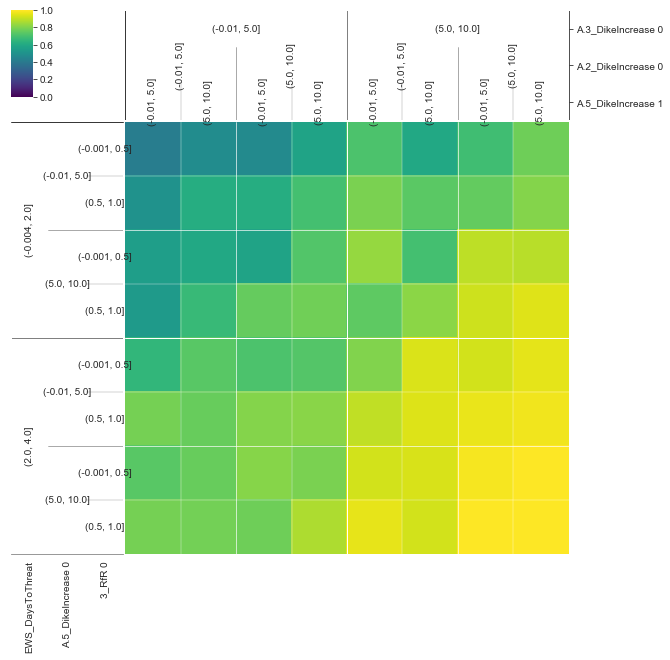

In [53]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes['Expected Number of Deaths'] < np.percentile(outcomes['Expected Number of Deaths'], q=75)

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [56]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.9)
box3a = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 3750 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.107, coverage: 0.14266666666666666, density: 1.0 restricted_dimensions: 7


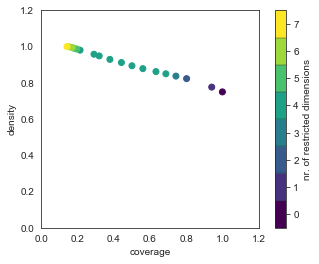

In [57]:
box3a.show_tradeoff()
plt.show()

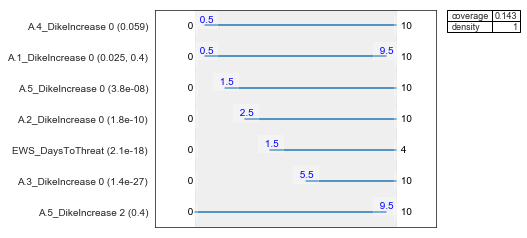

In [58]:
box3a.inspect(style='graph')
plt.show()

#### 3.2 Expected Number of Deaths < 0.5

Since we are also interested in the absolute outcome of the expected number of deaths, we use a threshold of < 0.5 to slice out the scenarios where no death were expected. Having the threshold "relaxed", we can see from dimensional stacking and especially PRIM that **early warning of evacuation for more than 0.5 days** is the most powerful lever.

[MainProcess/INFO] model dropped from analysis because only a single category


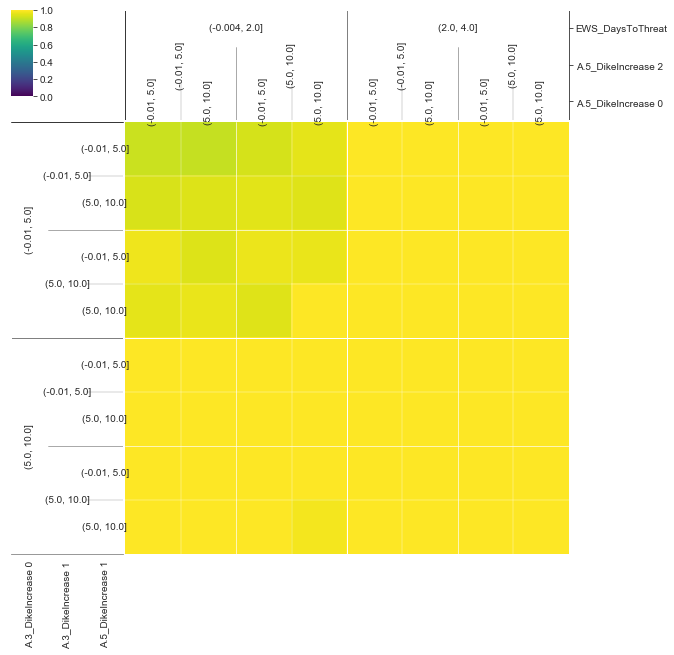

In [49]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes['Expected Number of Deaths'] < 0.5 # a hard threshold

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [50]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.9)
box3b = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 4919 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.595, coverage: 0.6047977231144541, density: 1.0 restricted_dimensions: 3


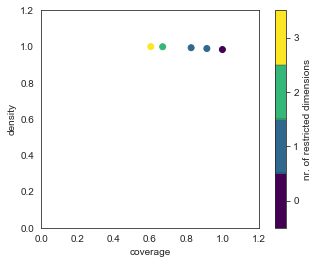

In [51]:
box3b.show_tradeoff()
plt.show()

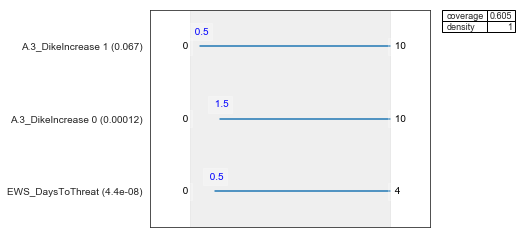

In [52]:
box3b.inspect(style='graph')
plt.show()

## Appendix

#### *The five sampled scenarios*

In [59]:
scenarios = experiments.loc[:, [u.name for u in dike_model.uncertainties]]
print(scenarios.drop_duplicates())

  discount rate 0 discount rate 1 discount rate 2  A.0_ID flood wave shape  \
0             1.5             1.5             1.5                     71.0   
1             3.5             3.5             3.5                     18.0   
2             2.5             4.5             1.5                    120.0   
3             4.5             2.5             3.5                     46.0   
4             4.5             1.5             4.5                    106.0   

     A.1_Bmax  A.1_pfail A.1_Brate    A.2_Bmax  A.2_pfail A.2_Brate  \
0   56.198915   0.260190       1.0  271.891532   0.672958       1.0   
1  171.301266   0.124975      10.0  212.920155   0.948767       1.5   
2  320.195902   0.506879      10.0  299.413513   0.381210       1.5   
3  121.394047   0.984563       1.5   59.783249   0.073313       1.0   
4  237.668548   0.682739       1.0  113.164901   0.552445      10.0   

     A.3_Bmax  A.3_pfail A.3_Brate    A.4_Bmax  A.4_pfail A.4_Brate  \
0   30.050875   0.703967      10.